# e-footprint quickstart

This notebook provides an example scenario that you can use to get familiar with the Python API of efootprint: the daily video consumption of all French households on a big streaming platform.

You will get to describe:

- the infrastructure involved (servers with auto-scaling settings, storage and network)
- the user journey involving 2 steps (Streaming, Upload)
- the usage pattern and the device population that executes it (the laptops of all French households)

## Import the packages

⚠ If this steps fails, remember to run *ipython kernel install --user --name=efootprint-kernel* _inside_ your python virtual environement (initializable with `poetry install`) to be able to select efootprint-kernel as the jupyter kernel.

In [1]:
# If this hasn’t been done in virtualenv (useful for Google colab notebook)
!pip install efootprint


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import os

from efootprint.abstract_modeling_classes.source_objects import SourceValue, Sources, SourceObject
from efootprint.abstract_modeling_classes.explainable_objects import EmptyExplainableObject
from efootprint.builders.hardware.storage_defaults import default_ssd
from efootprint.core.usage.user_journey import UserJourney
from efootprint.core.usage.user_journey_step import UserJourneyStep
from efootprint.core.usage.job import Job
from efootprint.core.hardware.servers.autoscaling import Autoscaling
from efootprint.core.hardware.storage import Storage
from efootprint.core.usage.usage_pattern import UsagePattern
from efootprint.core.hardware.network import Network
from efootprint.core.system import System
from efootprint.constants.countries import Countries
from efootprint.constants.units import u
from efootprint.utils.object_relationships_graphs import USAGE_PATTERN_VIEW_CLASSES_TO_IGNORE
from efootprint.builders.hardware.devices_defaults import default_laptop

## Define the infrastructure

An e-footprint object has a name and attributes describing its technical and environmental characteristics:

In [3]:
storage = Storage(
    "SSD storage",
    carbon_footprint_fabrication=SourceValue(160 * u.kg, Sources.STORAGE_EMBODIED_CARBON_STUDY),
    power=SourceValue(1.3 * u.W, Sources.STORAGE_EMBODIED_CARBON_STUDY),
    lifespan=SourceValue(6 * u.years, Sources.HYPOTHESIS),
    idle_power=SourceValue(0 * u.W, Sources.HYPOTHESIS),
    storage_capacity=SourceValue(1 * u.TB, Sources.STORAGE_EMBODIED_CARBON_STUDY),
    data_replication_factor=SourceValue(3 * u.dimensionless, Sources.HYPOTHESIS),
    data_storage_duration = SourceValue(2 * u.year, Sources.HYPOTHESIS),
    base_storage_need = SourceValue(100 * u.TB, Sources.HYPOTHESIS),
    fixed_nb_of_instances = EmptyExplainableObject()
    )

Moreover, all e-footprint objects have a *calculated_attributes* attributes that shows the list of attributes that are setup as None and then computed by e-footprint when the modeling is over. For example, for our storage:

In [4]:
print(storage)

Storage id-0891df-SSD-storage
 
carbon_footprint_fabrication: 160 kilogram
power: 1.3 watt
lifespan: 6 year
fraction_of_usage_time: 1 dimensionless
idle_power: 0 watt
storage_capacity: 1 terabyte
data_replication_factor: 3 dimensionless
data_storage_duration: 2 year
base_storage_need: 100 terabyte
fixed_nb_of_instances: no value
 
calculated_attributes:
  storage_delta: None
  full_cumulative_storage_need: None
  raw_nb_of_instances: None
  nb_of_instances: None
  nb_of_active_instances: None
  instances_fabrication_footprint: None
  instances_energy: None
  energy_footprint: None



Apart from environmental and technical attributes, e-footprint objects can link to other e-footprint objects. For example, Storage and Server objects can be linked to each other. A server can stored data on a storage device, and a storage device can be used by a server.

In [5]:
server = Autoscaling(
    "server",
    carbon_footprint_fabrication=SourceValue(600 * u.kg, Sources.BASE_ADEME_V19),
    power=SourceValue(300 * u.W, Sources.HYPOTHESIS),
    lifespan=SourceValue(6 * u.year, Sources.HYPOTHESIS),
    idle_power=SourceValue(50 * u.W, Sources.HYPOTHESIS),
    ram=SourceValue(128 * u.GB, Sources.HYPOTHESIS),
    cpu_cores=SourceValue(24 * u.core, Sources.HYPOTHESIS),
    power_usage_effectiveness=SourceValue(1.2 * u.dimensionless, Sources.HYPOTHESIS),
    average_carbon_intensity=SourceValue(100 * u.g / u.kWh, Sources.HYPOTHESIS),
    server_utilization_rate=SourceValue(0.9 * u.dimensionless, Sources.HYPOTHESIS),
    base_ram_consumption=SourceValue(300 * u.MB, Sources.HYPOTHESIS),
    base_cpu_consumption=SourceValue(2 * u.core, Sources.HYPOTHESIS),
    storage=storage
)

More information on e-footprint objects’ calculated_attributes can be found in the [e-footprint documentation](https://boavizta.github.io/e-footprint/).

## Define the user journey

This is the modeling of the average daily usage of the streaming platform in France:

In [6]:
streaming_step = UserJourneyStep(
    "20 min streaming",
    user_time_spent=SourceValue(20 * u.min, Sources.USER_DATA),
    jobs=[
        Job(
            "streaming",
            server=server,
            data_upload=SourceValue(0.05 * u.MB, Sources.USER_DATA),
            data_download=SourceValue(800 * u.MB, Sources.USER_DATA),
            data_stored=SourceValue(0.05 * u.MB, Sources.USER_DATA),
            request_duration=SourceValue(4 * u.min, Sources.HYPOTHESIS),
            cpu_needed=SourceValue(1 * u.core, Sources.HYPOTHESIS),
            ram_needed=SourceValue(50 * u.MB, Sources.HYPOTHESIS)
            )
        ]
    )
upload_step = UserJourneyStep(
    "1 min video capture then upload",
    user_time_spent=SourceValue(70 * u.s, Sources.USER_DATA),
    jobs=[
        Job(
            "video upload",
            server=server,
            data_upload=SourceValue(20 * u.MB, Sources.USER_DATA),
            data_download=SourceValue(0 * u.GB, Sources.USER_DATA),
            data_stored=SourceValue(20 * u.MB, Sources.USER_DATA),
            request_duration=SourceValue(2 * u.s, Sources.HYPOTHESIS),
            cpu_needed=SourceValue(1 * u.core, Sources.HYPOTHESIS),
            ram_needed=SourceValue(50 * u.MB, Sources.HYPOTHESIS)
        )
    ]
)

The user journey is then simply a list of user journey steps:

In [7]:
user_journey = UserJourney("Mean video consumption user journey", uj_steps=[streaming_step, upload_step])

## Describe usage

An e-footprint usage pattern links a user journey to devices that run it, a network, a country, and the number of times the user journey gets executed hour by hour. 

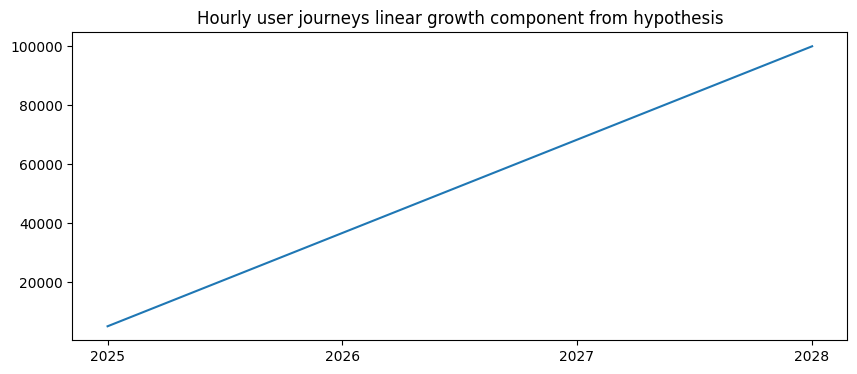

In [8]:
# Let’s build synthetic usage data by summing a linear growth with a sinusoidal fluctuation components, then adding daily variation
from datetime import datetime, timedelta

from efootprint.builders.time_builders import linear_growth_hourly_values

start_date = datetime.strptime("2025-01-01", "%Y-%m-%d")
timespan = 3 * u.year

linear_growth = linear_growth_hourly_values(timespan, start_value=5000, end_value=100000, start_date=start_date)
linear_growth.set_label("Hourly user journeys linear growth component")

linear_growth.plot()

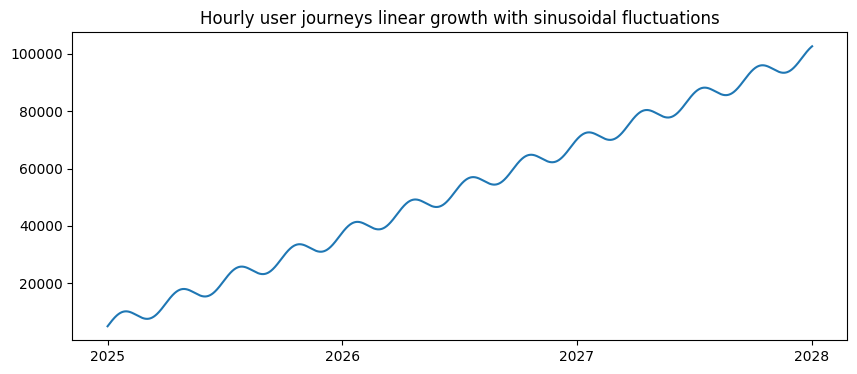

In [9]:
from efootprint.builders.time_builders import sinusoidal_fluct_hourly_values

sinusoidal_fluct = sinusoidal_fluct_hourly_values(
    timespan, sin_fluct_amplitude=3000, sin_fluct_period_in_hours=3 * 30 * 24, start_date=start_date)

lin_growth_plus_sin_fluct = (linear_growth + sinusoidal_fluct).set_label("Hourly user journeys linear growth with sinusoidal fluctuations")

lin_growth_plus_sin_fluct.plot()

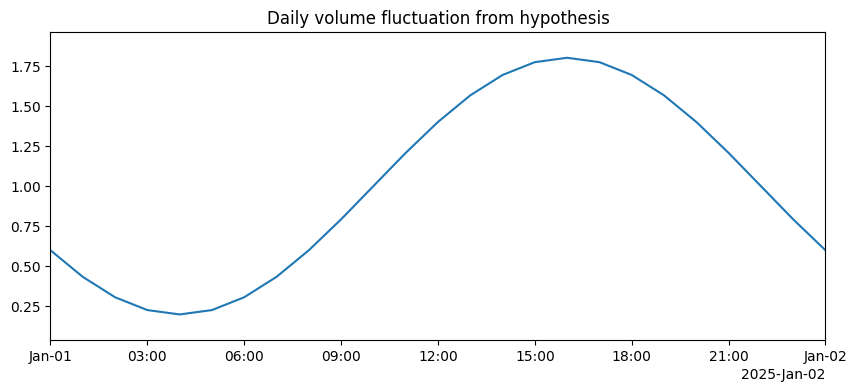

In [10]:
# Let’s add daily variations because people use the system less at night
from efootprint.builders.time_builders import daily_fluct_hourly_values

daily_fluct = daily_fluct_hourly_values(timespan, fluct_scale=0.8, hour_of_day_for_min_value=4, start_date=start_date)
daily_fluct.set_label("Daily volume fluctuation")

daily_fluct.plot(xlims=[start_date, start_date+timedelta(days=1)])

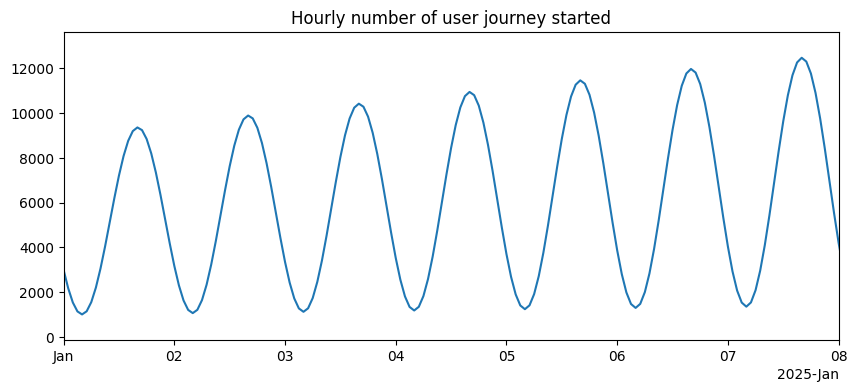

In [11]:
hourly_user_journey_starts = lin_growth_plus_sin_fluct * daily_fluct
hourly_user_journey_starts.set_label("Hourly number of user journey started")

hourly_user_journey_starts.plot(xlims=[start_date, start_date + timedelta(days=7)])

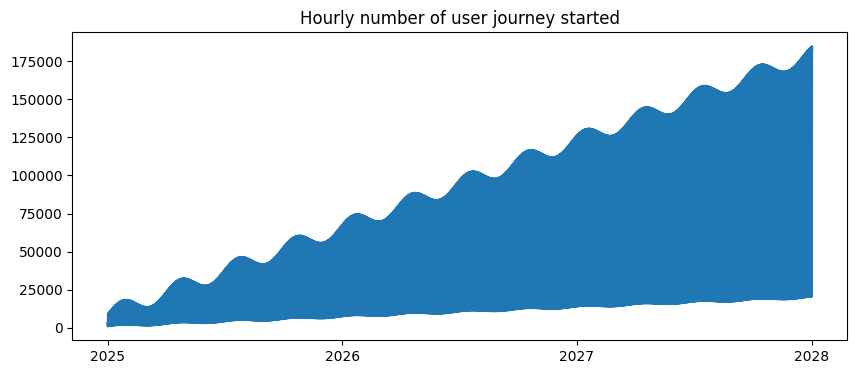

In [12]:
# Over 3 years the daily fluctuation color the area between daily min and max number of hourly user journeys
hourly_user_journey_starts.plot()

In [13]:
network = Network(
        "WIFI network",
        bandwidth_energy_intensity=SourceValue(0.05 * u("kWh/GB"), Sources.TRAFICOM_STUDY))

usage_pattern = UsagePattern(
    "Daily video streaming consumption",
    user_journey=user_journey,
    devices=[default_laptop()],
    network=network,
    country=Countries.FRANCE(),
    hourly_user_journey_starts=hourly_user_journey_starts
)

system = System("System", usage_patterns=[usage_pattern])

2024-11-08 15:00:24,768 - INFO - Computing calculated attributes for System System
2024-11-08 15:00:24,771 - INFO - Computing calculated attributes for UserJourney Mean video consumption user journey
2024-11-08 15:00:24,774 - INFO - Computing calculated attributes for UsagePattern Daily video streaming consumption
2024-11-08 15:00:24,794 - INFO - Computing calculated attributes for Job streaming
2024-11-08 15:00:24,809 - INFO - Computing calculated attributes for Job video upload
2024-11-08 15:00:24,821 - INFO - Computing calculated attributes for Autoscaling server
2024-11-08 15:00:24,853 - INFO - Computing calculated attributes for Network WIFI network
2024-11-08 15:00:24,871 - INFO - Computing calculated attributes for Storage SSD storage
2024-11-08 15:00:24,950 - INFO - Finished computing System modeling


## Results

### Computed attributes

Now all calculated_attributes have been computed:

In [14]:
print(server)

Autoscaling id-c8424b-server
 
carbon_footprint_fabrication: 600 kilogram
power: 300 watt
lifespan: 6 year
fraction_of_usage_time: 1 dimensionless
server_utilization_rate: 0.9 dimensionless
idle_power: 50 watt
ram: 128 gigabyte
cpu_cores: 24 core
power_usage_effectiveness: 1.2 dimensionless
average_carbon_intensity: 100.0 gram / kilowatt_hour
base_ram_consumption: 300 megabyte
base_cpu_consumption: 2 core
storage: id-0891df-SSD-storage
 
calculated_attributes:
  hour_by_hour_cpu_need: 26298 values from 2024-12-31 23:00:00 to 2028-01-01 16:00:00 in core:
    first 10 vals [201.67, 146.34, 103.76, 76.95, 67.89, 77.33, 104.78, 148.5, 205.65, 272.44],
    last 10 vals [4138.19, 5469.34, 6898.03, 8326.93, 9658.7, 10802.58, 11680.63, 12233.0, 12422.03, 12234.82]
  hour_by_hour_ram_need: 26298 values from 2024-12-31 23:00:00 to 2028-01-01 16:00:00 in GB:
    first 10 vals [10.08, 7.32, 5.19, 3.85, 3.39, 3.87, 5.24, 7.42, 10.28, 13.62],
    last 10 vals [206.91, 273.47, 344.9, 416.35, 482.93, 

### System footprint overview

In [15]:
system.plot_footprints_by_category_and_object("System footprints.html")

### Object relationships graph

Hover over a node to get the numerical values of its environmental and technical attributes. For simplifying the graph the Network and Hardware nodes are not shown.

In [16]:
usage_pattern.object_relationship_graph_to_file("object_relationships_graph.html", width="800px", height="500px",
    classes_to_ignore=USAGE_PATTERN_VIEW_CLASSES_TO_IGNORE, notebook=True)

object_relationships_graph.html


### Calculus graph

Any e-footprint calculation can generate its calculation graph for full auditability. Hover on a calculus node to display its formula and numeric value.

In [17]:
usage_pattern.devices_fabrication_footprint.calculus_graph_to_file(
    "device_population_fab_footprint_calculus_graph.html", width="800px", height="500px", notebook=True)

device_population_fab_footprint_calculus_graph.html


## Analysing the impact of a change
### Numeric input change
Any input change automatically triggers the computation of calculations that depend on the input. For example, let’s say that the average data download consumption of the streaming step decreased because of a change in default video quality:

In [18]:
streaming_step.jobs[0].data_download = SourceValue(500 * u.MB, Sources.USER_DATA)

Plotting the impact of streaming’s data_download changing from 800 megabyte to 500 megabyte


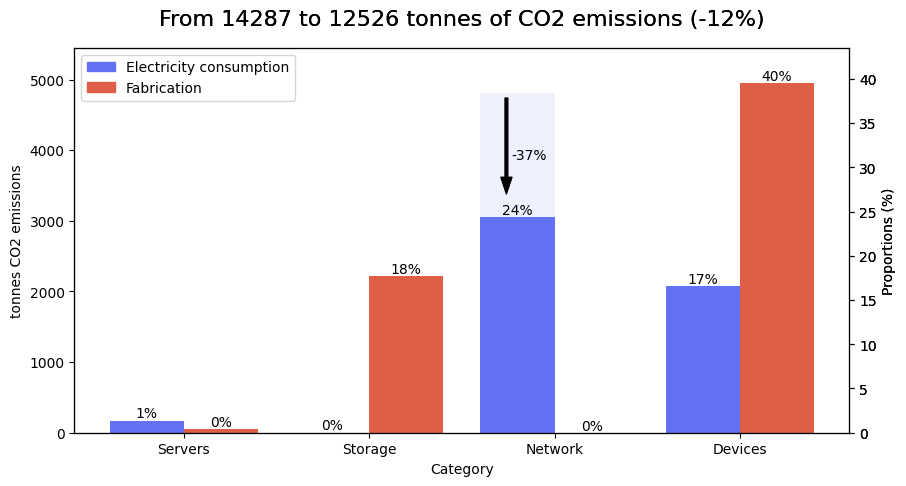

In [19]:
system.plot_emission_diffs("bandwith reduction.png")

### System structure change
Now let’s make a more complex change, like adding a conversation with a generative AI chatbot before streaming the video.
Numerical values don’t matter so much for the sake of this tutorial, please check out <a href="https://github.com/publicissapient-france/e-footprint-modelings" target="_blank">the e-footprint-modelings github repository</a> for a more detailed modeling of the impact of LLM training and inference.

In [20]:
llm_server = Autoscaling(
    "Inference GPU server",
    carbon_footprint_fabrication=SourceValue(4900 * u.kg, Sources.HYPOTHESIS),
    power=SourceValue(6400 * u.W, Sources.HYPOTHESIS),
    lifespan=SourceValue(5 * u.year, Sources.HYPOTHESIS),
    idle_power=SourceValue(500 * u.W, Sources.HYPOTHESIS),
    ram=SourceValue(128 * u.GB, Sources.HYPOTHESIS),
    cpu_cores=SourceValue(16 * u.core, Sources.HYPOTHESIS), # Used to represent GPUs because e-footprint doesn’t natively model GPU resources yet.
    power_usage_effectiveness=SourceValue(1.2 * u.dimensionless, Sources.HYPOTHESIS),
    average_carbon_intensity=SourceValue(300 * u.g / u.kWh, Sources.HYPOTHESIS),
    server_utilization_rate=SourceValue(1 * u.dimensionless, Sources.HYPOTHESIS),
    base_ram_consumption=SourceValue(0 * u.MB, Sources.HYPOTHESIS),
    base_cpu_consumption=SourceValue(0 * u.core, Sources.HYPOTHESIS),
    storage=default_ssd()
)

In [21]:
llm_chat_step = UserJourneyStep(
    "Chat with LLM to select video", user_time_spent=SourceValue(1 * u.min, Sources.HYPOTHESIS),
    jobs=[Job("LLM API call", llm_server, SourceValue(300 * u.kB, Sources.USER_DATA),
              SourceValue(300 * u.kB, Sources.USER_DATA), SourceValue(300 * u.kB, Sources.USER_DATA),
              request_duration=SourceValue(5 * u.s, Sources.HYPOTHESIS),
              cpu_needed=SourceValue(16 * u.core, Sources.HYPOTHESIS),
              ram_needed=SourceValue(128 * u.GB, Sources.HYPOTHESIS))])

In [22]:
# Adding the new step is simply an attribute update.
# Don’t use user_journey.uj_steps.append(llm_chat_step) as e-footprint recomputation logic wouldn’t be triggered
user_journey.uj_steps += [llm_chat_step]

2024-11-08 15:00:28,038 - INFO - Computing calculated attributes for UserJourney Mean video consumption user journey
2024-11-08 15:00:28,040 - INFO - Computing calculated attributes for UsagePattern Daily video streaming consumption
2024-11-08 15:00:28,063 - INFO - Computing calculated attributes for Job streaming
2024-11-08 15:00:28,082 - INFO - Computing calculated attributes for Job video upload
2024-11-08 15:00:28,114 - INFO - Computing calculated attributes for Job LLM API call
2024-11-08 15:00:28,145 - INFO - Computing calculated attributes for Autoscaling server
2024-11-08 15:00:28,217 - INFO - Computing calculated attributes for Network WIFI network
2024-11-08 15:00:28,259 - INFO - Computing calculated attributes for Autoscaling Inference GPU server
2024-11-08 15:00:28,304 - INFO - Computing calculated attributes for Storage SSD storage
2024-11-08 15:00:28,447 - INFO - Computing calculated attributes for Storage Default SSD storage


Plotting the impact of Mean video consumption user journey’s uj_steps changing from ['20 min streaming', '1 min video capture then upload'] to ['20 min streaming', '1 min video capture then upload', 'Chat with LLM to select video']


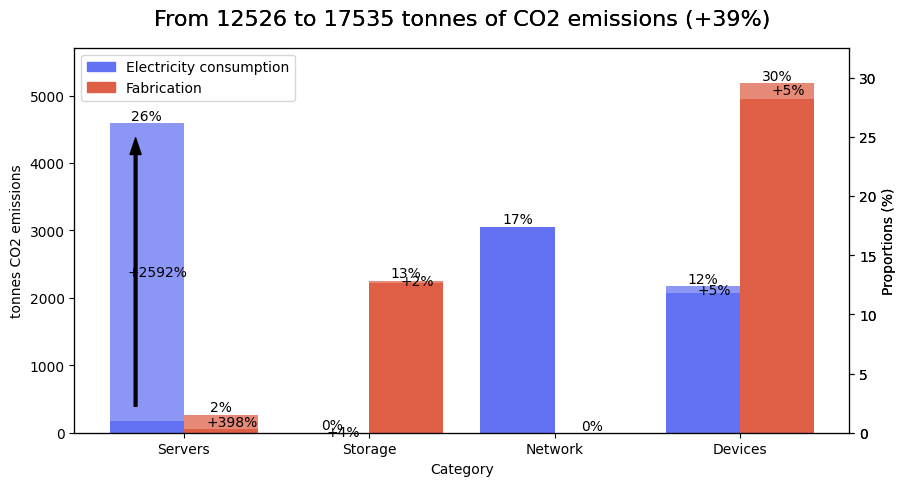

In [23]:
system.plot_emission_diffs("LLM chat addition.png")

We can see that server energy footprint has been multiplied by more than 10 and the rest of the impact is quite negligible. Good to know to make informed decisions ! Of course the impact is very much dependent on assumptions. If the LLM server ran on low-carbon electricity for example:

Plotting the impact of Inference GPU server’s average_carbon_intensity changing from 300.0 gram / kilowatt_hour to 50.0 gram / kilowatt_hour


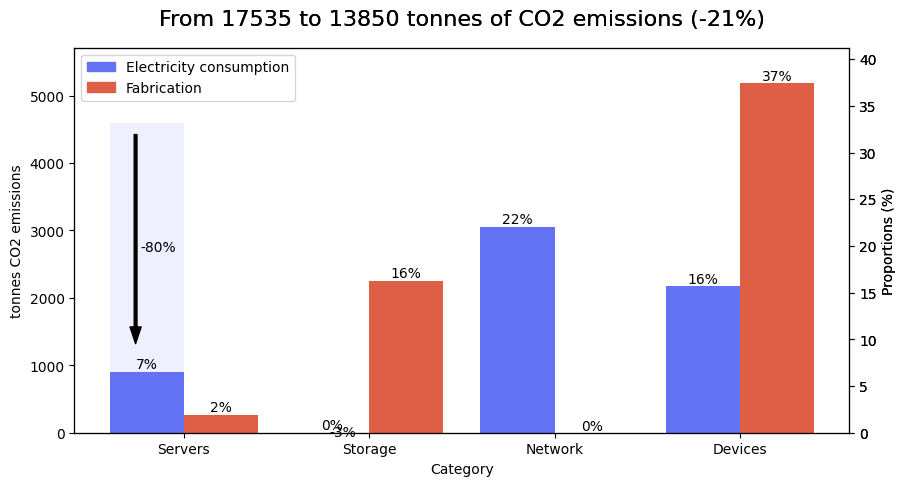

In [24]:
llm_server.average_carbon_intensity=SourceValue(50 * u.g / u.kWh, Sources.HYPOTHESIS)
system.plot_emission_diffs("lower LLM inference carbon intensity.png")

## Recap of all System changes

Plotting the impact of:

- streaming’s data_download changing from 800 megabyte to 500 megabyte
- Mean video consumption user journey’s uj_steps changing from ['20 min streaming', '1 min video capture then upload'] to ['20 min streaming', '1 min video capture then upload', 'Chat with LLM to select video']
- Inference GPU server’s average_carbon_intensity changing from 300.0 gram / kilowatt_hour to 50.0 gram / kilowatt_hour


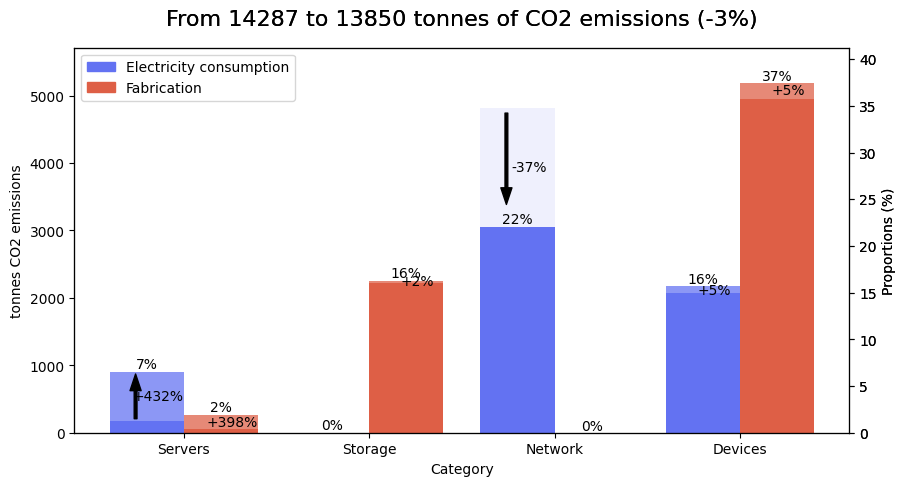

In [25]:
system.plot_emission_diffs("All system diffs.png", from_start=True)